<center><h1>Grid World Implementation with Q-learning </h1></center>

## Behzad Javaheri

The code in this task is inspired by:
1. https://www.youtube.com/watch?v=HGeI30uATws
2. https://www.youtube.com/watch?v=iKdlKYG78j4


In [69]:
# Importing required libraries
import numpy as np
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import matplotlib as mpl
#style.use("ggplot")
import itertools
from IPython.display import clear_output, set_matplotlib_formats, display
set_matplotlib_formats('retina')
import plotly.io as pio
pio.renderers.default='notebook'
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

#### Environment
The environment description is mostly similar to task 1. For this task, we aimed to introduce maximum stochasticity for the agent (mouse), end-goal terminal (cheese) and the trap (negative terminal). A bigger grid of 10x10 cells was defined. The location of the agent, end-goal and terminal trap was instructed to start at random states within the grid at the beginning of each episode. End-goal and trap were defined as terminal.

#### Agent, action and rewards 
Similar to task 1, there is a single agent with four potential actions of up, down, left and right and for each step, apart from cheese and trap, a negative reward of -1 is awarded. Big rewards are assigned to terminal states of trap (-100) and cheese (+100).

In [70]:
## Defining the size of the grid which will be 6x6
grid_Size = 10

## The number of episodes for training
episodes = 20000

In [71]:
## Defining rewards for moving mouse, trap and cheese which is the goal of our agent (mouse)
## We will have one agent and two terminal rewards: trap where our agents dies with maximm negative rewards and cheese
## where our agent reaches its goal
move_reward = -1
trap_reward = -100
cheese_reward = 100

#### Exploration vs exploitation
The type of action that an agent takes is determined by a balance between exploration & exploitation, achieved using epsilon greedy where epsilon is defined for the beginning and to decrease subsequently using epsilon decay. Therefore, early actions are more random and for later actions to be more directed by the Q-table. Epsilon 0.9, epsilon decay of 0.9999, a learning rate of 0.1, a discount factor of 0.95.

In [72]:
## Defining hyperparameters.
## These were changed to examine how they affect the performance

epsilon = 0.09 ## Defining epsilon
epsilon_decay = 0.9999  # Defining epsilon decay
learning_rate = 0.1 ## Defining learning rate
discount = 0.95 ## Defining discount rate


#### Implementation
The implementation was divided into the following steps: 

1) Setting parameters related to animation. This was to visualise the location of agent, trap and cheese for a selected display frequency. A colour dictionary was defined to assign colours to agent (blue), trap (red) and cheese (green).

2) The environment and actions were defined. The x and y coordinates of agent, trap and cheese were set to random for every episode within the grid and the reward for actions (up, down, right, left) was defined to be -1 unless the transition is into either trap or cheese which as described will award rewards of +100 and -100 respectively.

3) A function to define “move” was implemented to allow cheese and trap to move within an episode either individually or together.

4) Q-table and training are initialised in a loop and updated (Figs. 1-2). 5)  reward-episode graph plotted.

In [73]:
## Definition of parameters related to the animation !!!! This will work on Pycharm and not so smoothly on Jupyter !!!!
display_frequency = 1000  # how often to play through env visually.
mouse_key = 1  # mouse key in dictionary
food_key = 2  # cheese key in dictionary
trap_key = 3  # trap key in dictionary
colour_dict = {1: (255, 0, 0), # Dictionary for assigning colours to mouse, cheese and trap using above keys
     2: (0, 255, 0),           # OpenCV is used to show our environment which uses BGR and not RGB and as such the
     3: (0, 0, 255)}           # colours defined are Blue, Green and Red

In [74]:
## Defining our environment and action
class MouseGrid:
    def __init__(self):
        self.w = np.random.randint(0, grid_Size) ## The location of mouse, trap and reward is set randomly in each episode
        self.h = np.random.randint(0, grid_Size)
        self.grid = np.zeros((self.h, self.w)) - 1

        # Set random start location for the agent
        self.mouse = (4, np.random.randint(0, 9))

        # Set locations for the goal (cheese) and danger (trap)
        self.trap = (4, np.random.randint(0, 9))
        self.cheese = (4, np.random.randint(0, 9))
        self.terminal_states = [self.trap, self.cheese]

        # Set available actions
        self.actions = ['up', 'down', 'left', 'right'] # All possible actions

    def __sub__(self, other):
        return (self.w-other.w, self.h-other.h)
    
    def move_agent(self, action): #This will allow the agent to moce in specified direction
        # Store previous location
        last_location = self.mouse
    
    def fetch_reward(self, new_location): #This will return reward for taking an action
        return self.grid[new_location[0], new_location[1]]

    def available_actions(self): #This will return actions available to our agent
        return self.actions
        # moving up
        if action == 'up':
            if last_location[0] == 0:
                reward = self.fetch_reward(last_location)
            else:
                self.mouse = (self.mouse[0] - 1, self.mouse[1])
                reward = self.fetch_reward(self.mouse)
        # moving down
        elif action == 'down':
            if last_location[0] == self.h - 1:
                reward = self.fetch_reward(last_location)
            else:
                self.mouse = (self.mouse[0] + 1, self.mouse[1])
                reward = self.fetch_reward(self.mouse)
        # moving left
        elif action == 'left':
            if last_location[1] == 0:
                reward = self.fetch_reward(last_location)
            else:
                self.mouse = (self.mouse[0], self.mouse[1] - 1)
                reward = self.fetch_reward(self.mouse)
        # moving right
        elif action == 'right':
            if last_location[1] == self.w - 1:
                reward = self.fetch_reward(last_location)
            else:
                self.mouse = (self.mouse[0], self.mouse[1] + 1)
                reward = self.fetch_reward(self.mouse)

        return reward

    ## Our agent (mouse) has 4 potential actions to take: up, down, left and right to move non-diagonally: horizonla and vertical
    def action(self, action_type):
        if action_type == 0:
            self.move(h=1)
        elif action_type == 1:
            self.move(h=-1)
        elif action_type == 2:
            self.move(w=-1)
        elif action_type == 3:
            self.move(w=1)

    def move(self, w=False, h=False):
        # If no value for x, move randomly
        if not w:
            self.w += np.random.randint(-1, 2)
        else:
            self.w += w

        # If no value for y, move randomly
        if not h:
            self.h += np.random.randint(-1, 2)
        else:
            self.h += h

        # If we are out of bounds, fix!
        if self.w < 0:
            self.w = 0
        elif self.w > grid_Size-1:
            self.w = grid_Size-1
        if self.h < 0:
            self.h = 0
        elif self.h > grid_Size-1:
            self.h = grid_Size-1

    def query_terminal(self): #This will check whether the agent is in one of the termina states (cheese or trap), if true it will print "Agent in a terminal state"
        if self.mouse in self.terminal_states:
            return 'Agent in a terminal state'

class Random_Action(): #This will return a random choice amongst all possible actions
    def choose_action(self, possibl_available_actions):
        return np.random.choice(possible_available_actions)


On #0, epsilon is 0.09
1000 episode mean: nan
On #1000, epsilon is 0.08143496042027008
1000 episode mean: -122.784
On #2000, epsilon is 0.07368503087389953
1000 episode mean: -91.636
On #3000, epsilon is 0.06667263969758204
1000 episode mean: -68.443
On #4000, epsilon is 0.06032759749875011
1000 episode mean: -38.373
On #5000, epsilon is 0.05458639460622994
1000 episode mean: -23.147
On #6000, epsilon is 0.04939156538048424
1000 episode mean: -13.109
On #7000, epsilon is 0.044691113020610115
1000 episode mean: -5.944
On #8000, epsilon is 0.040437989110791044
1000 episode mean: -2.792
On #9000, epsilon is 0.03658962269680656
1000 episode mean: 9.263
On #10000, epsilon is 0.03310749417896732
1000 episode mean: 10.893
On #11000, epsilon is 0.029956749756428064
1000 episode mean: 22.261
On #12000, epsilon is 0.02710585256371836
1000 episode mean: 31.991
On #13000, epsilon is 0.024526267007600928
1000 episode mean: 22.204
On #14000, epsilon is 0.022192173144677325
1000 episode mean: 26.462


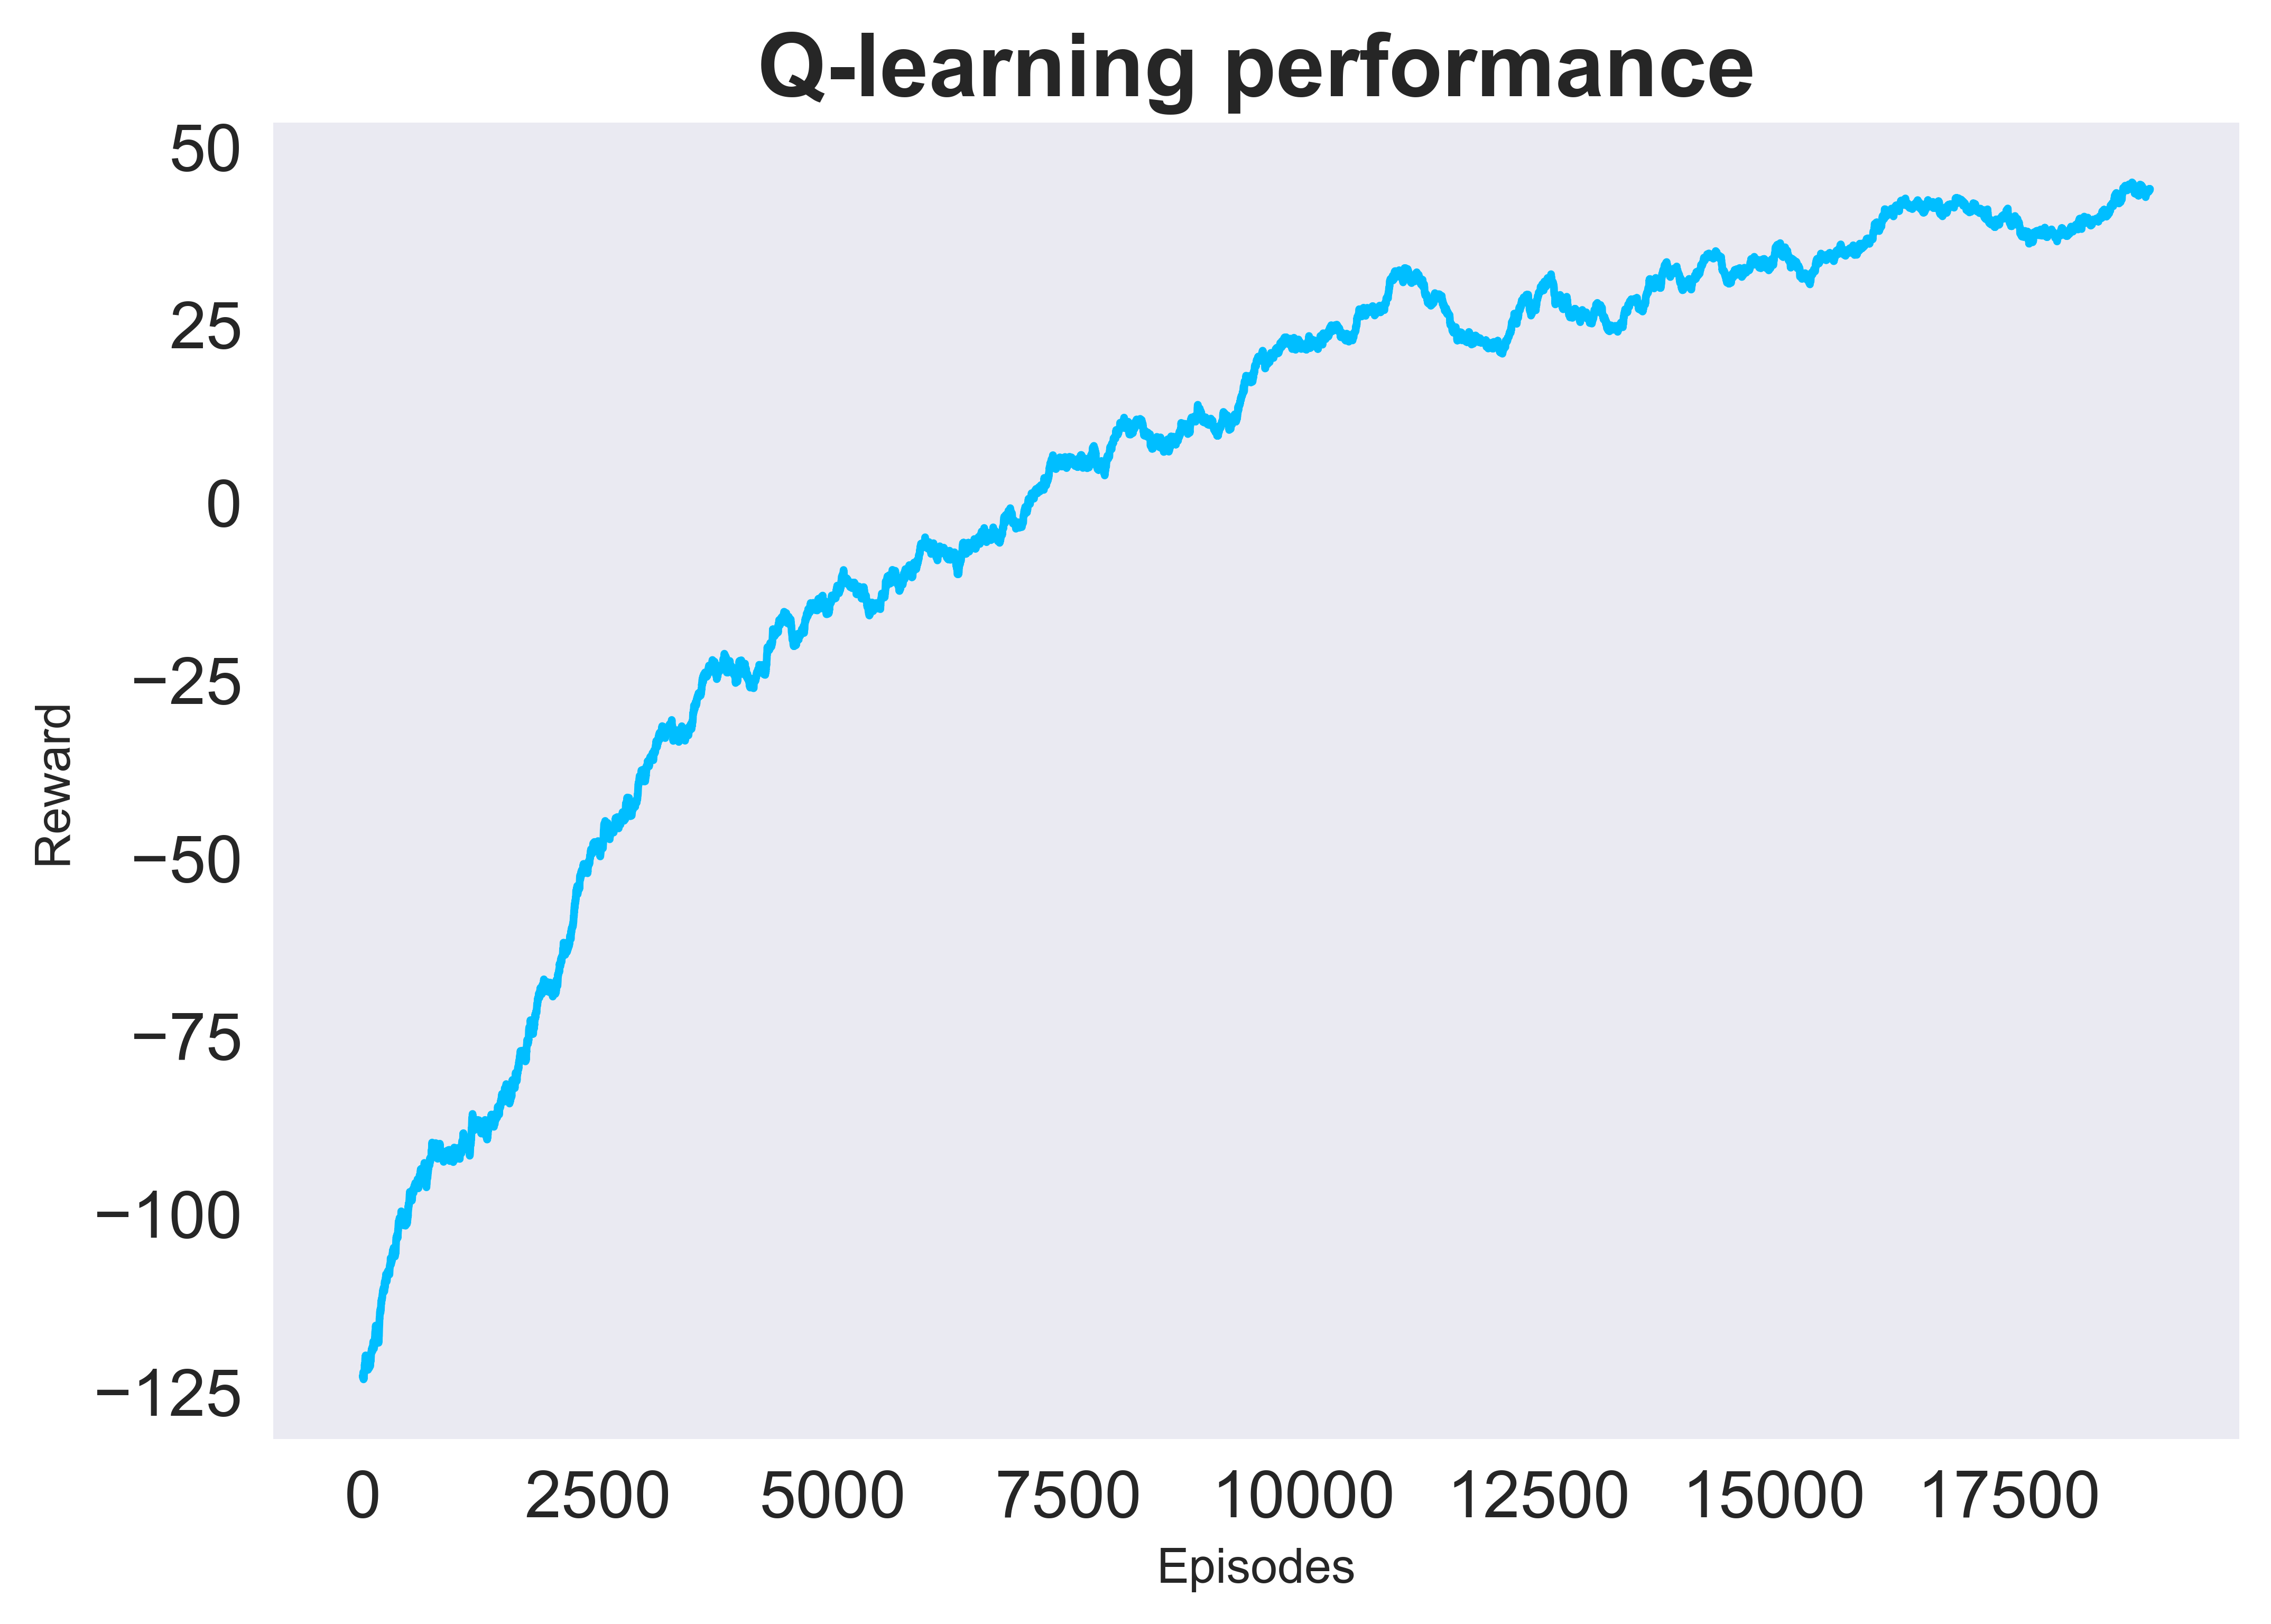

In [75]:
# initialize the q-table#
q_table = {}
for x1, y1, x2, y2 in itertools.product(range(-grid_Size + 1, grid_Size), repeat=4):
    q_table[((x1, y1), (x2, y2))] = [np.random.uniform(-5, 0) for i in range(4)]

## Define our reward system
episode_rewards = []

for episode in range(episodes):
    mouse = MouseGrid()
    cheese = MouseGrid()
    trap = MouseGrid()
    if episode % display_frequency == 0:
        print(f"On #{episode}, epsilon is {epsilon}")
        print(f"{display_frequency} episode mean: {np.mean(episode_rewards[-display_frequency:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    for i in range(500):
        obs = (mouse-cheese, mouse-trap)
        #print(obs)
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs]) ##Getting an action
        else:
            action = np.random.randint(0, 4)
        mouse.action(action) ##Taking an action

        #### Introducing stochasticity by allowing the cheese and trap to move either individually or together. These parameters were enabled when additional stochasticity introduced.
        #trap.move() #Uncommenting this will allow the trap to move around during training
        #cheese.move() #Uncommenting this will allow the cheese to move during training
        ##############

        if mouse.w == trap.w and mouse.h == trap.h:
            reward = trap_reward
        elif mouse.w == cheese.w and mouse.h == cheese.h:
            reward = cheese_reward
        else:
            reward = move_reward
        new_obs = (mouse-cheese, mouse-trap)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == cheese_reward:
            new_q = cheese_reward
        else:
            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)
        q_table[obs][action] = new_q

        if show:
            env = np.zeros((grid_Size, grid_Size, 3), dtype=np.uint8)  # starts an rbg of our size
            env[cheese.w][cheese.h] = colour_dict[food_key]  # sets the food location tile to green color
            env[mouse.w][mouse.h] = colour_dict[mouse_key]  # sets the mouse tile to blue
            env[trap.w][trap.h] = colour_dict[trap_key]  # sets the enemy location to red
            img = Image.fromarray(env, "RGB")  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((400, 400),resample=Image.BOX)  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            #plt.imshow(img)
            if reward == cheese_reward or reward == trap_reward:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == cheese_reward or reward == trap_reward:
            break

    
    episode_rewards.append(episode_reward) #This will allow to print episode rewards
    epsilon *= epsilon_decay

moving_avg = np.convolve(episode_rewards, np.ones((display_frequency,))/display_frequency, mode='valid')

#Plotting performance of Q-learning in our grid world using the defined hyperparameters
plt.plot([i for i in range(len(moving_avg))], moving_avg, color='#00BEFF')
plt.title("Q-learning performance", size=20, weight="bold")
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.xticks(size=15)
plt.yticks(size=15)
#plt.ylim(-100, 60)
plt.grid(b=None)
plt.style.use("seaborn")
plt.show()

#Saving the Q-table using Pickle
with open(f"qtable-{int()}.pickle", "wb") as f:
    pickle.dump(q_table, f)
    

env = MouseGrid()
agent = Random_Action()
